In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Oct 17 00:35:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install wandb

In [3]:
import tensorflow as tf
from tensorflow import keras

In [4]:
import wandb
from wandb.keras import WandbCallback

wandb.init(project="reviewer-changes-pedestrian-prediction-image")

wandb: Currently logged in as: victorsergio (use `wandb login --relogin` to force relogin)


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import datetime, os
import time as t

In [7]:
import pandas as pd
import numpy as np

In [8]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [9]:
from random import Random	

def sequences_to_supervised(dataframe, n_steps_in, n_steps_out, n_features):
  
  # the sequences must by arranged
  # in a supervised learning structure.
  # this function reads line by line each sequence and arrange in a supervised learning aproach structure
  # it's important to notice that sequences must not overlap, to mantain pedestrian independence
       
  X_all = np.empty([0,n_steps_in,n_features]) # n_features = number of features, x, y
  y_all = np.empty([0,n_steps_out,n_features]) # same here, n_features = number of features
       
  dataframe_groups = dataframe.groupby(['id'])
  
  # randomize sequences grouped by pedestrian id
  groups = list(dataframe.groupby(['id']))
  Random(77).shuffle(groups)
 

  for group in groups:
      
      
      id =group[1].iloc[0].id 

      # send pedestrian sequence dataframe to step split sequence function
      X, y = split_sequences(group[1].drop(columns=["id"]).values, n_steps_in,n_steps_out) # use 2 features, x, y
         
      X_all = np.concatenate((X_all,X))
      y_all = np.concatenate((y_all,y))
                   
  return X_all, y_all         

In [10]:
# hyperparameters

# choose a number of time steps
# previous time steps for each sequence split

n_features = 2   # x, y
n_steps_in = 8
n_steps_out = 12

In [11]:
root_path = '/content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction_simposio/'

In [12]:
# Create folder for the results
time_ = t.strftime("%Y%m%d-%H%M%S")

save_dir = root_path + 'results/' + time_
os.makedirs(save_dir)

In [13]:
# path variables

base_path = "/content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction_simposio/"
test_path = "/content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction_simposio/data/local-test/"


In [14]:
# Read and concat train datasets

train_files = [r'/content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction/data/train/stanford/bookstore_0.txt',
#               r'/content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction/data/train/stanford/bookstore_1.txt',
#               r'/content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction/data/train/stanford/bookstore_2.txt',
#               r'/content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction/data/train/stanford/bookstore_3.txt',
               r'/content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction/data/train/stanford/coupa_3.txt',
               r'/content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction/data/train/stanford/deathCircle_0.txt',
#               r'/content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction/data/train/stanford/deathCircle_1.txt',
#               r'/content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction/data/train/stanford/deathCircle_2.txt',
#               r'/content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction/data/train/stanford/deathCircle_3.txt',
#               r'/content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction/data/train/stanford/deathCircle_4.txt',
               r'/content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction/data/train/stanford/gates_0.txt',
#               r'/content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction/data/train/stanford/gates_1.txt',
#               r'/content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction/data/train/stanford/gates_3.txt',
#               r'/content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction/data/train/stanford/gates_4.txt',
#               r'/content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction/data/train/stanford/gates_5.txt',
#               r'/content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction/data/train/stanford/gates_6.txt',
#               r'/content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction/data/train/stanford/gates_7.txt',
#               r'/content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction/data/train/stanford/gates_8.txt',
               r'/content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction/data/train/stanford/hyang_4.txt',
#               r'/content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction/data/train/stanford/hyang_5.txt',
#               r'/content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction/data/train/stanford/hyang_6.txt',
#               r'/content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction/data/train/stanford/hyang_7.txt',
#               r'/content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction/data/train/stanford/hyang_9.txt',
               r'/content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction/data/train/stanford/nexus_0.txt',
#               r'/content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction/data/train/stanford/nexus_1.txt',
#               r'/content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction/data/train/stanford/nexus_2.txt',
#               r'/content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction/data/train/stanford/nexus_3.txt',
#               r'/content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction/data/train/stanford/nexus_4.txt',
#               r'/content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction/data/train/stanford/nexus_7.txt',
#               r'/content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction/data/train/stanford/nexus_8.txt',
#               r'/content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction/data/train/stanford/nexus_9.txt',
               r'/content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction/data/train/mot/PETS09-S2L1.txt',
               r'/content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction/data/train/crowds/arxiepiskopi1.txt',
               r'/content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction/data/train/crowds/crowds_zara02.txt',
#               r'/content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction/data/train/crowds/crowds_zara03.txt',
               r'/content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction/data/train/crowds/students001.txt',
#               r'/content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction/data/train/crowds/students003.txt',
               r'/content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction/data/train/biwi/biwi_hotel.txt'
             ]


	
# Create an empty Dataframe without any column names, indices or data
dataframe = pd.DataFrame()

number_of_files = 11; # 38 all

for i in range(number_of_files):
     data = pd.read_csv(train_files[i], sep=' ',header=None, names = ['time','id', 'x', 'y'])
     data['id'] = data['id'].apply(lambda x: str(i)+str(x))
     

     dataframe = pd.concat([dataframe,data],ignore_index=True)

dataframe.describe()

,time,x,y
count,79800.000000,79800.000000,79800.000000
mean,5012.259649,3.658732,7.153098
std,3739.179037,11.927135,12.432032
min,0.000000,-35.210000,-23.203000
25%,1768.500000,-4.206000,-0.979250
50%,4200.000000,5.739000,6.667000
75%,7870.000000,11.766250,14.244000
max,17960.000000,36.737000,62.131000


In [15]:
dataframe.head(42)

,time,id,x,y
0,0,0100,1.728,14.378
1,12,0100,2.035,14.378
2,24,0100,2.342,14.378
3,36,0100,2.630,14.378
4,48,0100,2.937,14.416
5,60,0100,3.244,14.416
6,72,0100,3.551,14.416
7,84,0100,3.782,14.416
8,96,0100,4.089,14.416
9,108,0100,4.242,14.512


In [15]:
dataframe.shape[0]

79800

In [ ]:
def to_relative_coord(dataframe):

    base = dataframe.iloc[0]

    for i in range(0, dataframe.shape[0]-1,1):
        
        if(i % 20 == 0):
            base= dataframe.iloc[i]

        dataframe.at[i, 'x'] = dataframe.at[i, 'x']-base.x
        dataframe.at[i, 'y'] = dataframe.at[i, 'y']-base.y

        

    return dataframe

In [ ]:
# convert x,y sequences, using x,y values relative to first step
#dataframe = to_relative_coord(dataframe)
#dataframe.head(42)


In [16]:
from sklearn.preprocessing import MinMaxScaler

# min max scaling
# normalize all columns but not id column
id_column = dataframe['id']
dataframe.drop(columns=['id','time'], axis=1, inplace=True) # we dont use the time column for trajectory prediction

scaler = MinMaxScaler()
dataframe = pd.DataFrame(scaler.fit_transform(dataframe), columns=dataframe.columns)

dataframe = dataframe.join(id_column) # re insert the id column to the scaled dataframe

# split the x and y features for multiple input model

dataframe_x = dataframe.drop(columns=['y'], axis=1)
dataframe_y = dataframe.drop(columns=['x'], axis=1)


#X1, y1 = sequences_to_supervised(dataframe, n_steps_in, n_steps_out, n_features)

X1, y1 = sequences_to_supervised(dataframe_x, n_steps_in, n_steps_out, 1)
X2, y2 = sequences_to_supervised(dataframe_y, n_steps_in, n_steps_out, 1) 

X,y = sequences_to_supervised(dataframe,n_steps_in,n_steps_out, n_features)

# show the prepared data dimensions with the supervised learning structure
# multivariate input, multivariate output, single step output, multistep input
print("supervised dataframe dimensions: ")
print(X1.shape, y1.shape,"\n")
print(X2.shape, y2.shape,"\n")
#print(X.shape, y.shape,"\n")
print(y.shape)



supervised dataframe dimensions: 
(3990, 8, 1) (3990, 12, 1) 

(3990, 8, 1) (3990, 12, 1) 

(3990, 12, 2)


In [17]:
# Save scaler to file
import pickle as pkl
with open(save_dir+"/train_scaler.pkl", "wb") as outfile:
    pkl.dump(scaler, outfile)

In [18]:
# show first 5 elements
for i in range(3):
    print(X1[i], y[i])

[[0.50634495]
 [0.50690091]
 [0.50787385]
 [0.50801284]
 [0.50773486]
 [0.50759587]
 [0.50662293]
 [0.505511  ]] [[0.50412109 0.27436895]
 [0.50370412 0.26921274]
 [0.50370412 0.26499402]
 [0.50384311 0.25983781]
 [0.50342613 0.25304099]
 [0.5039821  0.24765041]
 [0.50467705 0.24237701]
 [0.50564999 0.23686924]
 [0.50662293 0.23183022]
 [0.50773486 0.22491621]
 [0.50787385 0.21952563]
 [0.50926376 0.21378349]]
[[0.13186095]
 [0.13186095]
 [0.13186095]
 [0.13186095]
 [0.13133279]
 [0.13133279]
 [0.13133279]
 [0.13133279]] [[0.13133279 0.0784447 ]
 [0.13026255 0.08565167]
 [0.13026255 0.09172194]
 [0.13026255 0.0977922 ]
 [0.13026255 0.10387419]
 [0.12919232 0.10904212]
 [0.12919232 0.11511238]
 [0.12919232 0.12029203]
 [0.12919232 0.12838962]
 [0.12919232 0.13558488]
 [0.12919232 0.13761221]
 [0.12813599 0.14278013]]
[[0.30982529]
 [0.30982529]
 [0.30875506]
 [0.30875506]
 [0.30875506]
 [0.30769872]
 [0.30769872]
 [0.30769872]] [[0.30769872 0.48695713]
 [0.30769872 0.48695713]
 [0.30769

In [ ]:
# flatten input
#n_input = X.shape[1] * X.shape[2]
#X = X.reshape((X.shape[0], n_input))

# flatten conditional y
#n_input = y.shape[1] * y.shape[2]
#y = y.reshape((y.shape[0],n_input))

# flatten conditional y_test
#n_input = y_test.shape[1] * y_test.shape[2]
#y_test = y_test.reshape((y_test.shape[0],n_input))

# separate output
#y1 = y[:, 0].reshape((y.shape[0], 1))  # y with 2 features 
#y2 = y[:, 1].reshape((y.shape[0], 1))  # y with 2 features
#y_test = tf.keras.utils.to_categorical(y_test)
#y = tf.keras.utils.to_categorical(y)

# flatten test input
#n_input = X_test.shape[1] * X_test.shape[2]
#X_test = X_test.reshape((X_test.shape[0], n_input))

# separate test output
#y1_test = y_test[:, 0].reshape((y_test.shape[0], 1)) # y with 2 features
#y2_test = y_test[:, 1].reshape((y_test.shape[0], 1)) # y with 2 features

In [19]:
batch_size = 8

### Time2Vec

In [20]:
### DEFINE T2V LAYER ###

class T2V(tf.keras.layers.Layer):
    
    def __init__(self, output_dim=None, input_dim=None, **kwargs):
        self.output_dim = output_dim
        self.input_dim = input_dim
        super(T2V, self).__init__(**kwargs)
        
    def build(self, input_shape):

        self.W = self.add_weight(name='W',
                                shape=(1, 1, self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.P = self.add_weight(name='P',
                                shape=(1, 1, self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.w = self.add_weight(name='w',
                                shape=(1, 1, 1),
                                initializer='uniform',
                                trainable=True)

        self.p = self.add_weight(name='p',
                                shape=(1, 1, 1),
                                initializer='uniform',
                                trainable=True)

        super(T2V, self).build(input_shape)
        
    def call(self, x):
        #print("x: "+str(x.shape))
        m = self.w * x
        #print("m:"+str(m.shape))
        original = m + self.p
        #print("original:"+str(original.shape))
        x = tf.repeat(x, self.output_dim, -1)
        #print("repeat:"+str(x.shape))
        sin_trans = tf.math.sin(x * self.W + self.P)
        a = tf.concat([sin_trans,original], -1)
        #print("a:"+str(a.shape))
        return a

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], self.output_dim+1)

### LSTM Autoencoder

In [21]:
wandb.config.embedding_dim = 1

In [22]:
embedding_dim = wandb.config.embedding_dim
input_sequence_length = 8

input_layer_1 = tf.keras.Input(shape=(8,1))
input_layer_2 = tf.keras.Input(shape=(8,1))

#embedding_x = T2V(embedding_dim, input_sequence_length)(input_layer_1)
#embedding_y = T2V(embedding_dim, input_sequence_length)(input_layer_2)


merged_inputs = tf.keras.layers.concatenate([input_layer_1,input_layer_2],axis=1)
#merged_inputs = tf.keras.layers.concatenate([embedding_x,embedding_y],axis=1)


encoder = tf.keras.layers.Bidirectional( tf.keras.layers.LSTM(512, return_sequences=False, kernel_initializer='glorot_uniform'))(merged_inputs)
#encoder = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, kernel_initializer='glorot_uniform'))(encoder)
#encoder = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=False, kernel_initializer='glorot_uniform'))(encoder)

latent_vector = tf.keras.layers.RepeatVector(12)(encoder)

decoder = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True, kernel_initializer='glorot_uniform'))(latent_vector)
#decoder = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, kernel_initializer='glorot_uniform'))(decoder)
#decoder = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, kernel_initializer='glorot_uniform'))(decoder)
decoder = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=2, activation='linear'))(decoder)

model = tf.keras.Model([input_layer_1,input_layer_2], decoder)

model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=0.00001, epsilon=1e-08, decay=0.0), metrics=['mse', 'mae']) #0.00003


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8, 1)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 8, 1)]       0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 16, 1)        0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 1024)         2105344     concatenate[0][0]     

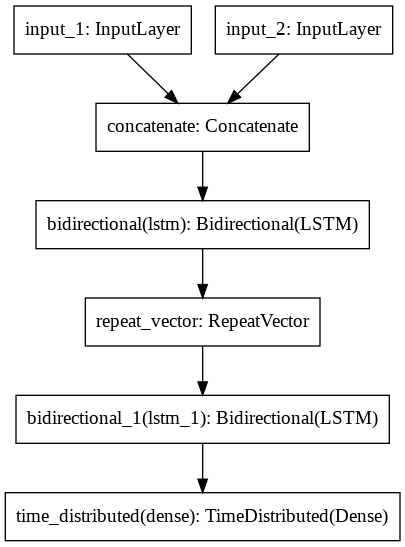

In [23]:
# summarize layers
print(model.summary())
# plot graph
tf.keras.utils.plot_model(model, to_file=save_dir+'/biLSTM-graph.png')

In [24]:
class CustomSaver(tf.keras.callbacks.Callback):
    def __init__(self,period,filename):
        self.period = period
        self.filename = filename

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.period == 0 :  # or save after some epoch, each k-th epoch etc.
            self.model.save(self.filename+"-{}".format(epoch))
            print("model saved to: {filename}-{epoch}".format(epoch=epoch,filename=self.filename))

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
# checkpoint
filepath = save_dir + "/biLSTM" 
checkpoint_callback = CustomSaver(period=10,filename=filepath)


# early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta = 0.000000001, patience=10, mode='min', restore_best_weights=True)

#wandb
wandb_callback = WandbCallback(monitor='val_loss', mode='min', log_gradients=False)


# callbacks
callbacks_list = [checkpoint_callback, early_stopping_callback,wandb_callback]


In [ ]:
#UNCOMMENT AND RUN THIS SECTION FOR RELOAD THE MODEL FROM LAST .HDF5 FILE AND CONTINUE TRAINING

# Reload model for re-training

#model = tf.keras.models.load_model('/content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction_simposio/results/20201016-213618/biLSTM')

In [26]:
# fit model

# 2 features x,y
# reverse
model_hist = model.fit([X1,X2],y, epochs=85, validation_split=0.2, batch_size = batch_size, verbose=2, callbacks=callbacks_list)

Epoch 1/85
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction_simposio/results/20201017-003617/biLSTM-0/assets
model saved to: /content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction_simposio/results/20201017-003617/biLSTM-0
399/399 - 24s - loss: 0.0324 - mse: 0.0324 - mae: 0.1252 - val_loss: 0.0064 - val_mse: 0.0064 - val_mae: 0.0632
Epoch 2/85
399/399 - 4s - loss: 0.0033 - mse: 0.0033 - mae: 0.0432 - val_loss: 0.0020 - val_mse: 0.0020 - val_mae: 0.0338
Epoch 3/85
399/399 - 4s - loss: 0.0016 - mse: 0.0016 - mae: 0.0281 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0247
Epoch 4/85
399/399 - 4s - loss: 0.0013 - mse: 0.0013 - mae: 0.0239 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0236
Epoch 5/85
399/

In [27]:
print(save_dir+"/biLSTM")
model.save(save_dir+"/biLSTM")

/content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction_simposio/results/20201017-003617/biLSTM
INFO:tensorflow:Assets written to: /content/drive/My Drive/RESEARCH/2020/Pedestrian_prediction_simposio/results/20201017-003617/biLSTM/assets


In [28]:
# 2 features, x, y
score = model.evaluate([X1,X2], y, verbose=1, batch_size=batch_size)

print("\n")
print(model.metrics_names)
print(score)

499/499 [==============================] - 2s 4ms/step - loss: 1.4518e-04 - mse: 1.4518e-04 - mae: 0.0077


['loss', 'mse', 'mae']
[0.00014517571253236383, 0.00014517568342853338, 0.007668364327400923]
